# Tensorflow Tutorial

In this file, I will follow the Tensorflow official tutorial to learn Tensorflow. The examples are from https://www.tensorflow.org/get_started/, https://www.tensorflow.org/tutorials/, and https://github.com/aymericdamien/TensorFlow-Examples. In the meantime, I probably will have my own small projects using Tensorflow. 

## Getting Started

In [1]:
import tensorflow as tf

The computational graph: Tensorflow Core programs consist of two discrete sections

1) Building the comptational graph

2) Ruing the computational graph

Computational graph is a series Tensorflow operations arranged into a graph of nodes. Let's build a simple computational graph. Each node takes zero or more tensors as inputs and produces a tensor as an output. 

There are several ways to generate tensors in tensorflow:

1) Create zero filled tensor

2) Create one filled tensor

3) Create a constant filled tensor

4) Create a tensor out of existing constant

In [4]:
row_dim = 5
col_dim = 4
zero_tsr = tf.zeros([row_dim, col_dim])
one_tsr = tf.ones([row_dim, col_dim])
filled_tsr = tf.fill([row_dim, col_dim], 30)
print zero_tsr
print one_tsr
print filled_tsr.value_index

Tensor("zeros_2:0", shape=(5, 4), dtype=float32)
Tensor("ones_2:0", shape=(5, 4), dtype=float32)
0


In [26]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0)
node3 = tf.constant(5.0)
print node1, node2, node3

Tensor("Const_1:0", shape=(), dtype=float32) Tensor("Const_2:0", shape=(), dtype=float32) Tensor("Const_3:0", shape=(), dtype=float32)


We also can initialize tensors with the same size as constant tensors

In [6]:
zeros_similar = tf.zeros_like(filled_tsr, dtype=tf.float32)
ones_similar = tf.ones_like(filled_tsr, dtype=tf.float32)
print zeros_similar
print ones_similar

Tensor("zeros_like_1:0", shape=(5, 4), dtype=float32)
Tensor("ones_like_1:0", shape=(5, 4), dtype=float32)


Sequence tensor:

1) tensor that contains defined intervals, linspace

2) range, has no stop value, no larger than the limit

In [18]:
lin_tsr = tf.linspace(start=0.0, stop=1.0, num=4)
seq_tsr = tf.range(start=6, limit=15, delta=4)

In [19]:
print lin_tsr
session = tf.Session()
print session.run(lin_tsr)
print session.run(seq_tsr)

Tensor("LinSpace_5:0", shape=(4,), dtype=float32)
[ 0.          0.33333334  0.66666669  1.        ]
[ 6 10 14]


Random tensors

1) generate random numbers from uniform distribution, uniform distribution draws from interval that includes the minval but not maxval (minval <= x < maxval), tf.random_uniform

2) generate random numbers from normal distribution,  tf.random_normal

3) generate normal dstributed random number within certain bounds

4) many other distributions, tf.random_gamma, tf.random_poisson

5) randomize entries of tensor and random crop

In [22]:
randunif_tsr = tf.random_uniform([row_dim, col_dim], minval=0, maxval=1)
randnorm_tsr = tf.random_normal([row_dim, col_dim], mean=0.0, stddev=1.0)
truncnorm_tsr = tf.truncated_normal([row_dim, col_dim], mean=0.0, stddev=1.0)
shuffled_output = tf.random_shuffle(lin_tsr)
crop_output = tf.random_crop(truncnorm_tsr, [2, 2])

We also can convert any numpy array to a python list or tensor using convert_to_tensor()

In [24]:
import numpy as np
nparry_tsr = tf.convert_to_tensor(np.zeros([row_dim, col_dim]), dtype=tf.float32)

To actually evaluate the nodes, we must run the computational graph within a session. A session encapsulates the control and state of the Tensorflow runtime. Create a Session object, and invoke its run method to run enough of the computational graph to evaluate. 

In [27]:
session = tf.Session()
print session.run(node1 + node2)
print session.run([node1, node2])
print session.run(lin_tsr)
print session.run(nparry_tsr)

7.0
[3.0, 4.0]
[ 0.          0.33333334  0.66666669  1.        ]
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [23]:
session = tf.Session()
print session.run(randunif_tsr)
print session.run(randnorm_tsr)
print session.run(truncnorm_tsr)
print session.run(shuffled_output)
print session.run(crop_output)

[[ 0.67220521  0.88252997  0.87040091  0.5287745 ]
 [ 0.01216948  0.39213681  0.12264264  0.61807251]
 [ 0.47416461  0.63431585  0.89741337  0.63506961]
 [ 0.13163936  0.95943093  0.30579436  0.50374854]
 [ 0.81866848  0.52330542  0.75306237  0.66046357]]
[[-1.26903236  0.0409077   0.80711061  0.51042491]
 [-1.13441634  0.20801598 -0.80274862 -0.52731907]
 [-1.1306833  -0.86152422 -0.42604628 -0.61735725]
 [-0.41518149  1.1687783   0.01400948 -2.51262808]
 [-0.81262809 -0.55688095 -0.15244453 -1.63101518]]
[[ 0.7241556   0.80209208 -0.49260613  0.0902128 ]
 [-0.74980783 -0.0526879   1.04567277  0.25060332]
 [-1.07460296  0.36734149 -1.48375738 -1.20853388]
 [-1.2501483  -0.10820613 -1.01182163  0.61372709]
 [ 0.11127156  0.76218736  0.68518704 -0.45744935]]
[ 0.33333334  1.          0.66666669  0.        ]
[[ 0.4480513  -0.11688936]
 [ 1.27591336 -0.57860464]]


We can build more complicated computation by combining tensor nodes with operations.

In [7]:
node4 = tf.add(node1, node2)
print "node4:", node4
print "session.run(node4)", session.run(node4)

node4: Tensor("Add:0", shape=(), dtype=float32)
session.run(node4) 7.0


A graph can be parameterized to accept external inputs, known as placeholders. A placeholder is a promise to provide a value later

In [8]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_note = a + b
print session.run(adder_note, {a: 3, b: 4.5})
print session.run(adder_note, {a: [1, 3], b: [2, 4]})

7.5
[ 3.  7.]


and then even more complex:

In [9]:
add_and_triple = adder_note * 3
print session.run(add_and_triple, {a: 3, b: 4.5})

22.5


Placeholders and Viarables are key tools for using computational graphs in TensorFlow. Placeholders are objects that allow us to feed in data of a specific type and shape; Variables are parameters of the algorithms and TensorFlow keeps track of how to change them to optimize the algorithm. 

To make machine learning model trainable, we need to be able to modify the graph to get new outputs with the same input. Variables allow us to add trainable parameters to graph. Variables are not initialised when we call tf.Variable. To initialize all variables in a Tensorflow programe, we have to explicitly call a special operation tf.global_variables_initializer(), or initialize individual variable

In [28]:
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b
init = tf.global_variables_initializer()
session.run(init)
print session.run(linear_model, {x:[1,2,3,4]})

[ 0.60000002  0.90000004  1.20000005  1.5       ]


In [29]:
first_var = tf.Variable(tf.zeros([2,3]))
session.run(first_var.initializer)
print session.run(first_var)

[[ 0.  0.  0.]
 [ 0.  0.  0.]]


In [13]:
y = tf.placeholder(tf.float32)
squared_delta = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_delta)
print session.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]})

34.46


### Working with Tensors (Matrices)

Operations:

1) substraction and addition

2) multiplication

3) transpose

4) determinant

5) inverse

6) Cholesky decomposition

7) Eig decomposotion

In [57]:
# Create tensor
A = tf.truncated_normal([row_dim, row_dim], dtype=tf.float32)
B = tf.random_uniform([row_dim, row_dim], minval=0.0, maxval=1.0, dtype=tf.float32)
I = tf.diag([1.0, 1.0, 1.0, 1.0, 1.0])
C = tf.constant([[4.0, 12.0, -16.0], [12.0, 37.0, -43.0], [-16.0, -43.0, 98]])

In [58]:
print session.run(A)
print session.run(B)
print session.run(I)
print session.run(A + B)
print session.run(tf.matmul(A, I))
print session.run(A * B)
print session.run(tf.transpose(A))
print session.run(tf.matrix_determinant(A))
print session.run(A + I)
print session.run(C)

[[ 0.28835264  0.85202426  0.14663243  0.04965334 -1.18171   ]
 [ 0.80420637 -0.50151879 -1.79141188  0.65549242  0.90004534]
 [ 0.79576313  0.06557913  1.75209534 -0.62952816  1.04075789]
 [-1.89137471  1.2208569  -1.4202323  -0.32099271  0.99774897]
 [ 0.29169032  1.17481732 -0.58979344  0.14824314 -0.37730548]]
[[ 0.93575859  0.57335174  0.60193658  0.62509537  0.62586379]
 [ 0.21421337  0.75724685  0.72821462  0.14992893  0.46883202]
 [ 0.08926964  0.18311167  0.23098516  0.96413124  0.03732681]
 [ 0.01663625  0.63220632  0.77189016  0.16132581  0.49116576]
 [ 0.70933104  0.20932198  0.41680527  0.96290016  0.29307556]]
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]
[[ 1.35256076  0.33575031  0.21167386 -1.35801697  0.70224404]
 [-0.716102    1.8844744  -0.68451655  0.37460348  1.19382465]
 [ 1.88630247 -0.44183975  0.70136338  1.07921016  1.49334764]
 [-0.21656865  1.41611254  0.27470335 -0.04084647  2.16279745]


In [63]:
print session.run(tf.matrix_inverse(A + I))
print session.run(tf.cholesky(C))
print session.run(tf.self_adjoint_eig(C))

[[ 0.61088479 -0.3788543   0.40556699  0.20249388  1.53914201]
 [-0.72652572  1.12742352 -0.56908506  0.06942733 -2.99128628]
 [ 0.2317276   0.08472069 -0.17366321 -1.28366911 -2.18164802]
 [-1.37309873  0.96186256 -0.79974335  1.30925131 -2.23302913]
 [-0.48274976  0.28136587 -1.65196383  0.82243121 -1.02588248]]
[[ 2.  0.  0.]
 [ 6.  1.  0.]
 [-8.  5.  3.]]
(array([  1.88096873e-02,   1.55039663e+01,   1.23477234e+02], dtype=float32), array([[ 0.96341878,  0.21272728,  0.16300693],
       [-0.26483005,  0.84895217,  0.45732397],
       [ 0.04109978,  0.48376369, -0.87423301]], dtype=float32))


### Activation Functions

The activation functions are in the nueral networks (nn) package in TensorFlow.

1) relu
2) relu6
3) sigmoid
4) tanh
5) softsign
6) softplus
7) softmax
8) exponential linear unit (elu)

In [66]:
print session.run(tf.nn.relu([-0.3, 0.7, 0.1]))
print session.run(tf.nn.softmax([-0.3, 0.7, 0.1]))
print session.run(tf.nn.sigmoid([-0.3, 0.7, 0.1]))
print session.run(tf.nn.softmax([-0.3, 0.7, 0.1]))
print session.run(tf.nn.tanh([-0.3, 0.7, 0.1]))
print session.run(tf.nn.softsign([-0.3, 0.7, 0.1]))
print session.run(tf.nn.softplus([-0.3, 0.7, 0.1]))
print session.run(tf.nn.elu([-0.3, 0.7, 0.1]))

[ 0.          0.69999999  0.1       ]
[ 0.19193467  0.52173251  0.28633291]
[ 0.42555749  0.66818774  0.52497917]
[ 0.19193467  0.52173251  0.28633291]
[-0.29131261  0.60436779  0.09966799]
[-0.23076925  0.41176468  0.09090909]
[ 0.55435526  1.10318601  0.74439669]
[-0.2591818   0.69999999  0.1       ]


### Data sources
There are some widely used datasets avaible for benchmarking

In [69]:
# Iris data
from sklearn import datasets
iris = datasets.load_iris()
print iris.target_names
print iris.feature_names
print iris.data.shape

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
(150, 4)


In [83]:
# Birth weight data
import pandas as pd
birthdata_url = 'http://courses.washington.edu/b513/datasets/lowbwt.dta'
birth_data = pd.read_stata(birthdata_url)
print birth_data.columns
print birth_data.shape

Index([u'id', u'lbw', u'age', u'lwt', u'race', u'smoke', u'ptl', u'hyper',
       u'urirr', u'pvft', u'weight', u'agecat', u'wcat', u'anyptl',
       u'newpvft'],
      dtype='object')
(189, 15)


In [92]:
# Boston housing data
import requests
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 
                  'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV0']
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]
print pd.DataFrame(housing_data, columns=housing_header).head()

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV0  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


In [94]:
# MNIST handwriting data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [31]:
# Spam-ham text data
import requests
import io
from zipfile import ZipFile
zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
r = requests.get(zip_url)
z = ZipFile(io.BytesIO(r.content))
title_file = z.read('SMSSpamCollection')
text_data = title_file.decode('utf-8')
text_data = text_data.encode('ascii',errors='ignore')
text_data = text_data.decode().split('\n')
text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]
print len(text_data_train)

5574


In [33]:
# Movie review data
import requests
import io
import tarfile
movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
r = requests.get(movie_data_url)
# Stream data into temp object
stream_data = io.BytesIO(r.content)
tmp = io.BytesIO()
while True:
    s = stream_data.read(16384)
    if not s:
        break
    tmp.write(s)
stream_data.close()
tmp.seek(0)
# Extract tar file
tar_file = tarfile.open(fileobj=tmp, mode="r:gz")
pos = tar_file.extractfile('rt-polaritydata/rt-polarity.pos')
neg = tar_file.extractfile('rt-polaritydata/rt-polarity.neg')
# Save pos/neg reviews (Also deal with encoding)
pos_data = []
for line in pos:
    pos_data.append(line.decode('ISO-8859-1').encode('ascii',errors='ignore').decode())
neg_data = []
for line in neg:
    neg_data.append(line.decode('ISO-8859-1').encode('ascii',errors='ignore').decode())
tar_file.close()
print(len(pos_data))
print(len(neg_data))
# Print out first negative review
print(neg_data[0])


5331
5331
simplistic , silly and tedious . 



In [41]:
# CIFAR-10 image data
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict
data = unpickle('../../Datasets/DataScience/cifar-10/data_batch_1')
print data['data'].shape, len(data['labels'])

(10000, 3072) 10000


In [1]:
# Shakespear text data
import requests
shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
# Get Shakespeare text
response = requests.get(shakespeare_url)
shakespeare_file = response.content
# Decode binary into string
shakespeare_text = shakespeare_file.decode('utf-8')
# Drop first few descriptive paragraphs.
shakespeare_text = shakespeare_text[7675:]
print(len(shakespeare_text)) # Number of characters

5582212


In [30]:

# Englis-German translation
import requests
import io
from zipfile import ZipFile
sentence_url = 'http://www.manythings.org/anki/deu-eng.zip'
r = requests.get(sentence_url)
z = ZipFile(io.BytesIO(r.content))
file = z.read('deu.txt''')
# eng_ger_data = file.split('\n')
# eng_ger_data = [x.split('\t') for x in eng_ger_data if len(x)>=1]
# [english_sentence, german_sentence] = [list(x) for x in zip(*eng_ger_data)]
# print(len(english_sentence))
# Format Data
eng_ger_data = file.decode('utf-8')
eng_ger_data = eng_ger_data.encode('ascii''',errors='ignore''')
eng_ger_data = eng_ger_data.decode().split('\n')
eng_ger_data = [x.split('\t') for x in eng_ger_data if len(x)>=1]
[english_sentence, german_sentence] = [list(x) for x in zip(*eng_ger_data)]
print(len(english_sentence))

152557


## Key Components
### Operations in a computational graph

In [43]:
import tensorflow as tf
import numpy as np
sess = tf.Session()
x_vals = np.array([1., 3., 5., 7., 9.])
x_data = tf.placeholder(tf.float32)
m_const = tf.constant(3.)
prod = tf.multiply(x_data, m_const)
for x in x_vals:
    print sess.run(prod, {x_data:x})

3.0
9.0
15.0
21.0
27.0


### Layering Nested Operations

In [52]:
array_1 = np.array([[1., 3., 5., 7., 9.], [-2., 0., 2., 4., 6.], [-6., -3., 0., 3., 6.]])
array_2 = np.array([array_1, array_1 + 1.])
x_data = tf.placeholder(dtype=tf.float32, shape=(3,None))
m1 = tf.constant([[1.],[0.],[-1.],[2.],[4.]])
m2 = tf.constant([[2.]])
m3 = tf.constant([[10.]])
prod_1 = tf.matmul(x_data, m1)
prod_2 = tf.matmul(prod_1, m2)
add_1 = tf.add(prod_2, m3)

for x in array_2:
    print sess.run(add_1, feed_dict={x_data:x})

[[ 102.]
 [  66.]
 [  58.]]
[[ 114.]
 [  78.]
 [  70.]]


### Loss Functions

[ 1.16012561]
[ 0.00012564]


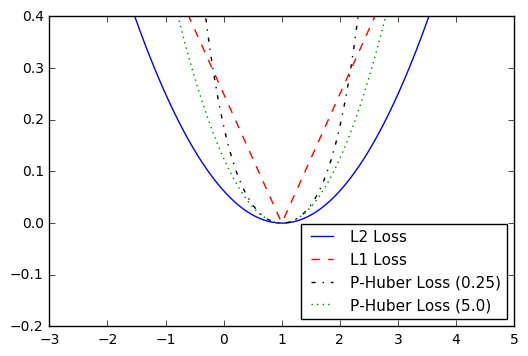

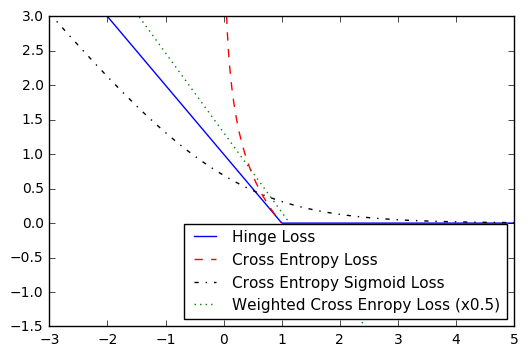

In [58]:
import matplotlib.pyplot as plt
import tensorflow as tf
x_vals = tf.linspace(-1., 1., 500)
target = tf.constant(0.)

# 1, L2 Norm loss also known as Euclidean loss function
l2_y_vals = tf.square(target - x_vals)
l2_y_out = sess.run(l2_y_vals)

# 2, L1 Norm loss 
l1_y_vals = tf.abs(target -  x_vals)
l1_y_out = sess.run(l1_y_vals)

# 3, Pseudo-Huber loss
delta1 = tf.constant(0.25)
delta2 = tf.constant(5.)
phuber1_y_vals = tf.multiply(tf.square(delta1), (tf.square(1. + tf.square((target - x_vals)/delta1)) - 1.))
phuber1_y_out = sess.run(phuber1_y_vals)
phuber2_y_vals = tf.multiply(tf.square(delta2), (tf.square(1. + tf.square((target - x_vals)/delta2)) - 1.))
phuber2_y_out = sess.run(phuber2_y_vals)


x_vals = tf.linspace(-3., 5., 500)
target = tf.constant(1.)
targets = tf.fill([500,], 1.)

# 4, hinge loss
hinge_y_vals = tf.maximum(0., 1. - tf.multiply(target, x_vals))
hinge_y_out = sess.run(hinge_y_vals)

# 5, cross entropy loss
xentropy_y_vals = - tf.multiply(target, tf.log(x_vals)) - tf.multiply(1. - target, tf.log(1. - x_vals))
xentropy_y_out = sess.run(xentropy_y_vals)

# 6, sigmoid cross entropy loss
xentropy_sigmoid_y_vals = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_vals, labels=targets)
xentropy_sigmoid_y_out = sess.run(xentropy_sigmoid_y_vals)

# 7, Weighted cross entropy loss 
weight = tf.constant(0.5)
xentropy_weighted_y_vals = tf.nn.weighted_cross_entropy_with_logits(x_vals, targets, weight)
xentropy_weighted_y_out = sess.run(xentropy_weighted_y_vals)

# 8, Softmax cross-entropy loss
unscaled_logits = tf.constant([[1., -3., 10.]])
target_dist = tf.constant([[0.1, 0.02, 0.88]])
softmax_xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=unscaled_logits, labels=target_dist)
print sess.run(softmax_xentropy)

# 9, Sparse softmax cross-entropy loss
unscaled_logits = tf.constant([[1., -3., 10.]])
sparse_target_dist = tf.constant([2])
sparse_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=unscaled_logits, labels=sparse_target_dist)
print(sess.run(sparse_xentropy))

x_array = sess.run(x_vals)
plt.plot(x_array, l2_y_out, 'b-', label='L2 Loss')
plt.plot(x_array, l1_y_out, 'r--', label='L1 Loss')
plt.plot(x_array, phuber1_y_out, 'k-.', label='P-Huber Loss (0.25)')
plt.plot(x_array, phuber2_y_out, 'g:', label='P-Huber Loss (5.0)')
plt.ylim(-0.2, 0.4)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()
         
x_array = sess.run(x_vals)
plt.plot(x_array, hinge_y_out, 'b-', label='Hinge Loss')
plt.plot(x_array, xentropy_y_out, 'r--', label='Cross Entropy Loss')
plt.plot(x_array, xentropy_sigmoid_y_out, 'k-.', label='Cross Entropy Sigmoid Loss')
plt.plot(x_array, xentropy_weighted_y_out, 'g:', label='Weighted Cross Enropy Loss (x0.5)')
plt.ylim(-1.5, 3)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()



### Back Propagation
Tensorflow provides optimizers that slowly change each variable in order to minimize the loss function. The simplest optimizer is gradient descent. it modifies each variable according to the magnitude of the derivatives of loss with respect to that variable. Tensorflow can automatically produce deritives given only a description of the model using function tf.gradients.  

In [61]:
import tensorflow as tf

W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b
init = tf.global_variables_initializer()
y = tf.placeholder(tf.float32)
squared_delta = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_delta)
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
sess = tf.Session()
sess.run(init)
for i in range(1000):
    sess.run(train, {x:[1,2,3,4], y:[0,-1,-2,-3]})
    
print(sess.run([W, b]))
print(sess.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]}))

[array([-0.99999791], dtype=float32), array([ 0.99999392], dtype=float32)]
2.52847e-11


### Batch and stochastic training 

In [80]:

import numpy as np
import tensorflow as tf
sess = tf.Session()
batch_size = 20
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
my_output = tf.matmul(x_data, A)
loss = tf.reduce_mean(tf.square(my_output - y_target))
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)


In [79]:
loss_batch = []
for i in range(100):
    rand_index = np.random.choice(100, size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    if (i+1)%5==0: 
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        print('Loss = ' + str(temp_loss))
        loss_batch.append(temp_loss)

Step #5 A = [[ 1.99626088]]
Loss = 64.1249
Step #10 A = [[ 3.49261308]]
Loss = 40.866
Step #15 A = [[ 4.68950939]]
Loss = 29.3438
Step #20 A = [[ 5.66176271]]
Loss = 18.2803
Step #25 A = [[ 6.45234728]]
Loss = 13.5158
Step #30 A = [[ 7.0991807]]
Loss = 8.95487
Step #35 A = [[ 7.61376762]]
Loss = 6.5578
Step #40 A = [[ 8.03359699]]
Loss = 3.59243
Step #45 A = [[ 8.36335659]]
Loss = 3.51681
Step #50 A = [[ 8.61612797]]
Loss = 2.32376
Step #55 A = [[ 8.8303318]]
Loss = 1.53192
Step #60 A = [[ 9.01692677]]
Loss = 2.04913
Step #65 A = [[ 9.20790768]]
Loss = 2.07864
Step #70 A = [[ 9.33077145]]
Loss = 1.1014
Step #75 A = [[ 9.43239689]]
Loss = 1.34036
Step #80 A = [[ 9.4919014]]
Loss = 1.00239
Step #85 A = [[ 9.54374313]]
Loss = 1.14466
Step #90 A = [[ 9.60393238]]
Loss = 0.998372
Step #95 A = [[ 9.61843204]]
Loss = 0.943095
Step #100 A = [[ 9.66773129]]
Loss = 1.30747


In [81]:
loss_stochastic = []
for i in range(100):
    rand_index = np.random.choice(100, size=100)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%5==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        print('Loss = ' + str(temp_loss))
        loss_stochastic.append(temp_loss)


Step #5 A = [[ 2.10739279]]
Loss = 62.119
Step #10 A = [[ 3.5604713]]
Loss = 41.8913
Step #15 A = [[ 4.74361324]]
Loss = 26.6776
Step #20 A = [[ 5.70292997]]
Loss = 17.848
Step #25 A = [[ 6.48119593]]
Loss = 12.3767
Step #30 A = [[ 7.11774778]]
Loss = 9.2537
Step #35 A = [[ 7.63358498]]
Loss = 5.86062
Step #40 A = [[ 8.03398132]]
Loss = 3.83404
Step #45 A = [[ 8.36007309]]
Loss = 2.37239
Step #50 A = [[ 8.64226246]]
Loss = 2.22664
Step #55 A = [[ 8.85687923]]
Loss = 1.93679
Step #60 A = [[ 9.02501297]]
Loss = 1.47379
Step #65 A = [[ 9.17415524]]
Loss = 1.63364
Step #70 A = [[ 9.28565121]]
Loss = 1.3478
Step #75 A = [[ 9.37216282]]
Loss = 1.58021
Step #80 A = [[ 9.46166801]]
Loss = 1.48554
Step #85 A = [[ 9.53729057]]
Loss = 0.941603
Step #90 A = [[ 9.59429455]]
Loss = 1.2342
Step #95 A = [[ 9.63478184]]
Loss = 1.03325
Step #100 A = [[ 9.66355133]]
Loss = 0.945652


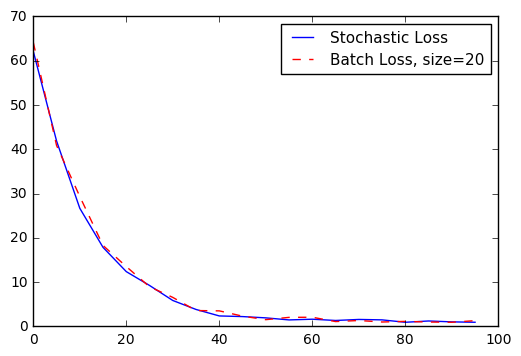

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(0, 100, 5), loss_stochastic, 'b-', label='Stochastic Loss')
plt.plot(range(0, 100, 5), loss_batch, 'r--', label='Batch Loss, size=20')
plt.legend(loc='upper right', prop={'size': 11})
plt.show()

### Example
Using a simple example, we can combine what we learned above together. In this example, we will build a linear model for iris data.

In [139]:
# import all packages needed
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
sess = tf.Session()

# load data
iris = datasets.load_iris()
# Because iris data has three classes, for a binary model, we need to transfor the target data to 0 and 1
# In this case, if the target is 0, i.e. setosa, the label is 1, otherwise the label is 0 
binary_target = np.array([1. if x == 0 else 0. for x in iris.target])
iris_2d = np.array([[x[2], x[3]] for x in iris.data])
# Batch size
batch_size = 20
# 2 placeholders for input and output
x_data = tf.placeholder(dtype=tf.float32, shape=[None, 2])
y_label = tf.placeholder(dtype=tf.float32, shape=[None, 1])
# Variable for the model
W = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
# linear model y_hat = Wx + b
y_hat = tf.add(tf.matmul(x_data, W), b)
# loss is sigmoid cross entropy
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat, labels=y_label))
# Optimizer SGD
optimizer = tf.train.GradientDescentOptimizer(0.08)
train = optimizer.minimize(loss)
# Initialization
init = tf.global_variables_initializer()
sess.run(init)
#print 'Loss: ', sess.run(y_hat)
# training
for epoch in range(1000):
    rand_index = np.random.choice(len(iris_2d), size=batch_size)
    rand_x = iris_2d[rand_index]
    rand_y = np.array([[y] for y in binary_target[rand_index]])
    sess.run(train, feed_dict={x_data: rand_x, y_label: rand_y})
    if (epoch+1)%200==0:
        print('Step #' + str(i+1) + ' W = ' + str(sess.run(W)) +', b = ' + str(sess.run(b)))
        print 'Loss: ', sess.run(loss, feed_dict={x_data: rand_x, y_label: rand_y})



Step #150 W = [[-0.84128398]
 [-0.25092167]], b = [[ 1.63704216]]
Loss:  0.216522
Step #150 W = [[-1.02338815]
 [-0.69344664]], b = [[ 2.70842767]]
Loss:  0.129016
Step #150 W = [[-1.1757592 ]
 [-0.99183577]], b = [[ 3.42844009]]
Loss:  0.0883954
Step #150 W = [[-1.29702044]
 [-1.21324623]], b = [[ 3.95529079]]
Loss:  0.0501888
Step #150 W = [[-1.39665067]
 [-1.39374089]], b = [[ 4.37458849]]
Loss:  0.0630145


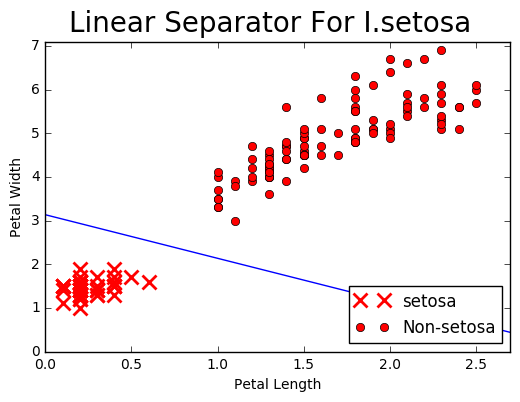

In [140]:
A = sess.run(W)
B = sess.run(b)
x = np.linspace(0, 3, num=50)
ablineValues = []
for i in x:
    ablineValues.append((-B - A[1]*i)/A[0])
ablineValues = [v[0][0] for v in ablineValues]
setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==1]
setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==1]
non_setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==0]
non_setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==0]
plt.plot(setosa_x, setosa_y, 'rx', ms=10, mew=2, label='setosa')
plt.plot(non_setosa_x, non_setosa_y, 'ro', label='Non-setosa')
plt.plot(x, ablineValues, 'b-')
plt.xlim([0.0, 2.7])
plt.ylim([0.0, 7.1])
plt.suptitle('Linear Separator For I.setosa', fontsize=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc='lower right')
plt.show()


### Evaluate models

In [ ]:
tf.get_variable

tf.contrib.learn is a high-level Tensorflow library that simplifies the mechanisms of machine learning, including 

1) running training loops 

2) running evaluation loops, 

3) managing data sets, 

4) managing feeding.

Basic useage: a much simpler linear regression program

In [168]:
import tensorflow as tf
import numpy as np
features = [tf.contrib.layers.real_valued_column("x", dimension=1)]
estimator = tf.contrib.learn.LinearRegressor(feature_columns=features)
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_train}, y_train, batch_size=4, num_epochs=1000)
eval_input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_eval}, y_eval, batch_size=4, num_epochs=1000)
estimator.fit(input_fn=input_fn, steps=1000)
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print "train loss: %r" % train_loss
print "evaluation loss: %r" % eval_loss

train loss: {'loss': 1.0086203e-06, 'global_step': 1000}
evaluation loss: {'loss': 0.0026156974, 'global_step': 1000}


A custom model:

In [23]:
tf.logging.set_verbosity(tf.logging.ERROR) # turn off warning

In [24]:
import tensorflow as tf
import numpy as np

def model(features, labels, mode):
    W = tf.get_variable("W", [1], dtype=tf.float64)
    b = tf.get_variable("b", [1], dtype=tf.float64)
    y = W * features['x'] + b
    loss = tf.reduce_sum(tf.square(y - labels))
    globe_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss),
                     tf.assign_add(globe_step, 1))
    return tf.contrib.learn.ModelFnOps(mode=mode, predictions=y, loss=loss, train_op=train)

estimator = tf.contrib.learn.Estimator(model_fn=model)
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_train}, y_train, 4, num_epochs=1000)
eval_input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_eval}, y_eval, batch_size=4, num_epochs=1000)
estimator.fit(input_fn=input_fn, steps=1000)
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
print "train loss: %r" % train_loss
print "evaluation loss: %r" % eval_loss

train loss: {'loss': 2.4748615e-11, 'global_step': 1000}
evaluation loss: {'loss': 0.010100762, 'global_step': 1000}


## Basic Models
### MNIST Example 

Read data

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Nearest neighbour model
Some basic models:
The first model, nearest neighbour model

In [179]:
# build the graph
x_train, y_train = mnist.train.next_batch(20000)
x_test, y_test = mnist.test.next_batch(2000)

xtr_v = tf.placeholder("float", [None, 784])
xte_v = tf.placeholder("float", [784])

distance = tf.reduce_sum(tf.abs(tf.add(xtr_v, tf.negative(xte_v))), reduction_indices=1)
pred = tf.arg_min(distance, 0)
accuracy = 0.
init = tf.global_variables_initializer()

# launch the graph
with tf.Session() as sess:
    sess.run(init)    
    for i in range(x_test.shape[0]):
        nn_index =  sess.run(pred, feed_dict={xtr_v:x_train, xte_v: x_test[i, :]})
        # print "Test", i, "Prediction:", np.argmax(y_train[nn_index]), "True Class:", np.argmax(y_test[i])
        if np.argmax(y_train[nn_index]) == np.argmax(y_test[i]):
            accuracy += 1./x_test.shape[0]
print "Done! Accuracy: %f" % accuracy

Done! Accuracy: 0.952000


In [37]:
session.run(distance, {xtr_v:x_train, xte_v: x_test[i, :]})

array([ 129.21961975,  131.29019165,  136.71372986, ...,  120.22745514,
        142.92156982,  138.54508972], dtype=float32)

### Linear regression
### House price prediction in Boston area


The second model: Linear regression, example house price prediction in Boston area

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np

from numpy import genfromtxt
from sklearn.datasets import load_boston

# load data
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def read_boston_data():
    boston = load_boston()
    features = np.array(boston.data)
    labels = np.array(boston.target)
    return features, labels

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

features,labels = read_boston_data()
normalized_features = feature_normalize(features)
f, l = append_bias_reshape(normalized_features,labels)
n_dim = f.shape[1]

rnd_indices = np.random.rand(len(f)) < 0.80

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]


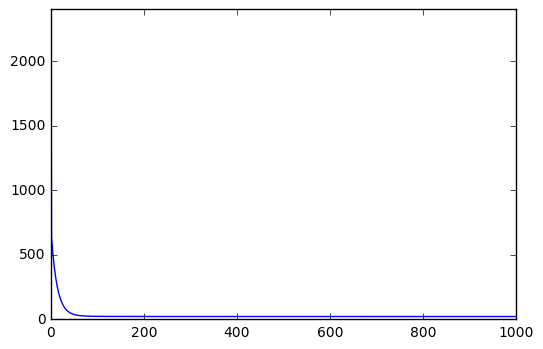

In [164]:
learning_rate = 0.01
training_epochs = 1000
rng = np.random
cost_history = np.empty(shape=[1],dtype=np.float32)
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(rng.randn(n_dim, 1), name="weight", dtype=tf.float32)
b = tf.Variable(rng.randn(), name="bias", dtype=tf.float32)

y_ = tf.matmul(X, W) + b
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 19.7016


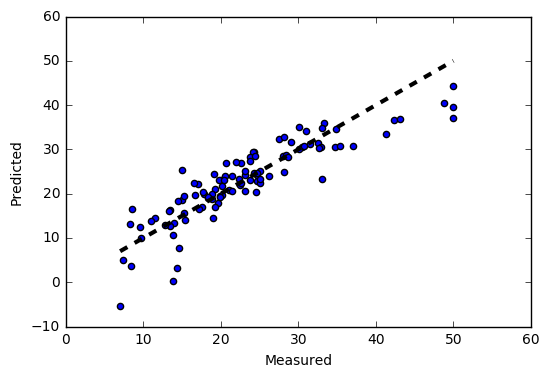

In [165]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Goodness-of-fit: a common way to summarize how well a linear regression model fits the data is via the coefficient of determination or R^2. This is calculated as the square of correlation between the observed y values and the predicted value y_hat. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [166]:
from sklearn.metrics import r2_score
print "R2 score: %f" % r2_score(test_y, pred_y)

R2 score: 0.774475


### Nonlinear regression
use an one hidden layer neural network as a regression model 

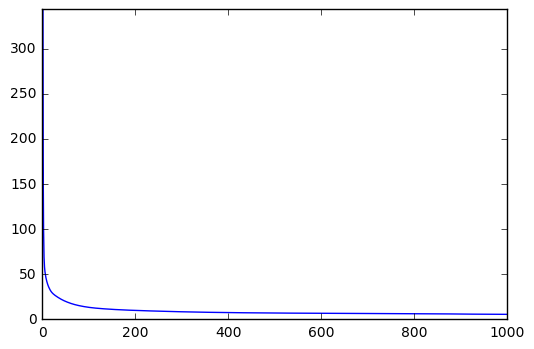

In [157]:
learning_rate = 0.05
momentum = 0.9
training_epochs = 1000
hidden = 9
cost_history = np.empty(shape=[1],dtype=float)
X = tf.placeholder(tf.float32,[None, n_dim])
Y = tf.placeholder(tf.float32,[None, 1])
W1 = tf.Variable(rng.randn(n_dim, hidden), name="weight", dtype=tf.float32)
b1 = tf.Variable(rng.randn(hidden), name="bias", dtype=tf.float32)
W2 = tf.Variable(rng.randn(hidden, 1), name="weight", dtype=tf.float32)
b2 = tf.Variable(rng.randn(), name="bias", dtype=tf.float32)
h1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
y_ = tf.matmul(h1, W2) + b2
cost = tf.reduce_mean(tf.square(y_ - Y))
# training_step = tf.train.AdagradDAOptimizer(learning_rate).minimize(cost)
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True).minimize(cost)
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 7.5087


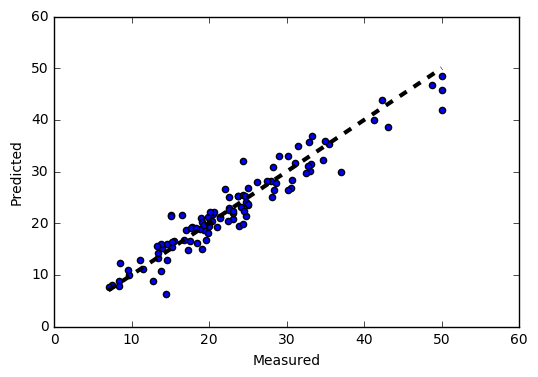

In [158]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [159]:
from sklearn.metrics import r2_score
print "R2 score: %f" % r2_score(test_y, pred_y)

R2 score: 0.914047


Nonlinear regression: use an one hidden layer neural network as a regression model (tensorflow layer implementation)

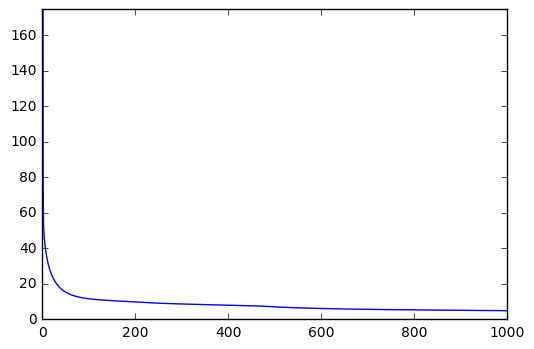

In [161]:
learning_rate = 0.05
momentum = 0.9
training_epochs = 1000
hidden = 9

X = tf.placeholder(tf.float32,[None, n_dim])
Y = tf.placeholder(tf.float32,[None, 1])
cost_history = np.empty(shape=[1],dtype=np.float32)
layer1 = tf.layers.dense(X, hidden, activation=tf.nn.sigmoid)
Wo = tf.Variable(rng.randn(hidden, 1), name="weight", dtype=tf.float32)
bo = tf.Variable(rng.randn(), dtype=tf.float32)
y_ = tf.matmul(layer1, Wo) + bo

cost = tf.reduce_mean(tf.square(y_ - Y))
# training_step = tf.train.AdagradDAOptimizer(learning_rate).minimize(cost)
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True).minimize(cost)
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 8.3247


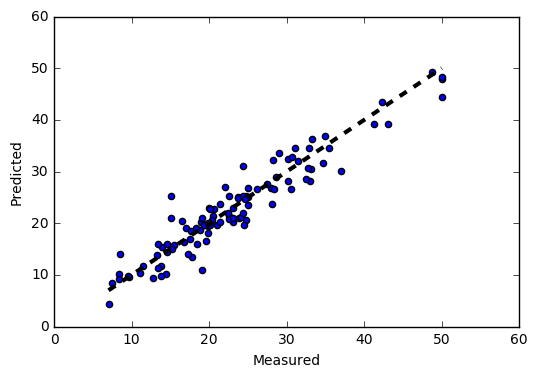

In [162]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [163]:
from sklearn.metrics import r2_score
print "R2 score: %f" % r2_score(test_y, pred_y)

R2 score: 0.904707


### Logistic regression
Using MNIST data

 Epoch: 0010 cost= 1.293231719
Epoch: 0020 cost= 0.928310808
Epoch: 0030 cost= 0.790747981
Epoch: 0040 cost= 0.713607731
Epoch: 0050 cost= 0.655491050
Epoch: 0060 cost= 0.619245792
Epoch: 0070 cost= 0.588894196
Epoch: 0080 cost= 0.563403022
Epoch: 0090 cost= 0.540182225
Epoch: 0100 cost= 0.519066210
Accuracy: 0.883667


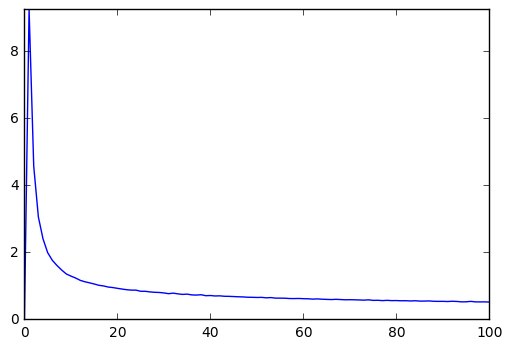

In [177]:
import tensorflow as tf
import numpy as np
learning_rate = 0.01
training_epoch = 100
batch_size = 100
display_step = 10
ndim = 784
nclass = 10
rng = np.random
cost_history = np.empty(shape=[1],dtype=float)

x = tf.placeholder(tf.float32, [None, ndim])
y = tf.placeholder(tf.float32, [None, nclass])

W = tf.Variable(rng.randn(ndim, nclass), name='weights', dtype=tf.float32)
b = tf.Variable(rng.randn(nclass), name='bias', dtype=tf.float32)
y_ = tf.nn.softmax(tf.matmul(x, W) + b)
# minimizing cross entropy
# y_ = tf.nn.softmax(tf.matmul(x, W) + b)
# cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_), reduction_indices=1))

# directly use tf.nn.softmax_cross_entropy_with_logits
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.matmul(x, W) + b, labels=y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for epoch in xrange(training_epoch):
    total_batch = int(mnist.train.num_examples/batch_size)
    avg_cost = 0.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c = sess.run([optimizer, cost], feed_dict={x:batch_xs, y:batch_ys})
        avg_cost += c / total_batch        
    if (epoch+1) % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)    
    cost_history = np.append(cost_history,avg_cost)
    
# Test model
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
# Calculate accuracy for 3000 examples
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print "Accuracy:", accuracy.eval(session=sess, feed_dict={x: mnist.test.images[:3000], 
                                                          y: mnist.test.labels[:3000]})

plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epoch,0,np.max(cost_history)])
plt.show()

### Deep Neural Networks
Build a Multilayer Convolutional Network

In [ ]:
import tensorflow as tf
ndim = 784
n_classes = 10
num_epochs = 100
cost_history = np.empty(shape=[1],dtype=float)
batch_size = 100
learning_rate = 0.01
# initialize variable
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution and Pooling
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

# weights and bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': weight_variable([5, 5, 1, 32]),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': weight_variable([5, 5, 32, 64]),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': weight_variable([7*7*64, 1024]),
    # 1024 inputs, 10 outputs (class prediction)
    'out': weight_variable([1024, n_classes])
}

biases = {
    'bc1': bias_variable([32]),
    'bc2': bias_variable([64]),
    'bd1': bias_variable([1024]),
    'out': bias_variable([n_classes])
}

# input and labels
x = tf.placeholder(tf.float32, [None, ndim])
y = tf.placeholder(tf.float32, [None, n_classes])
dropout = tf.placeholder(tf.float32)

# create model
# def conv_net(x, weights, bias, dropout):
input_x = tf.reshape(x, shape=[-1, 28, 28, 1])
conv1 = conv2d(input_x, weights['wc1'], biases['bc1'])
conv1 = maxpool2d(conv1, k=2) # downsampling

conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
conv2 = maxpool2d(conv2, k=2)

# fully connected

fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.matmul(fc1, weights['wd1']) + biases['bd1']
# batch normalization
fc1 = tf.contrib.layers.batch_norm(fc1, center=True, scale=True)
fc1 = tf.nn.relu(fc1)

# Apply Dropout
fc1 = tf.nn.dropout(fc1, dropout)

y_ = tf.nn.softmax(tf.matmul(fc1, weights['out']) + biases['out'])
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in xrange(num_epochs):
        total_batch = int(mnist.train.num_examples/batch_size)
        avg_cost = 0.
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={x:batch_xs, y:batch_ys,
                                                          dropout:0.75})
            avg_cost += c / total_batch
            
        if (epoch+1) % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: mnist.test.images[3000:6000],
                                                              y: mnist.test.labels[3000:6000],
                                                              dropout: 1.})
            print "Epoch:", '%3d' % (epoch+1), "cost=%.5f" % loss, "accuracy=%.5f" % acc 
        cost_history = np.append(cost_history,avg_cost)
        
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
# Calculate accuracy for 3000 examples
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print "Accuracy:", accuracy.eval(session=sess, feed_dict={x: mnist.test.images[:3000], 
                                                          y: mnist.test.labels[:3000],
                                                          dropout: 1.})

plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epoch,0,np.max(cost_history)])
plt.show()

Epoch:  10 cost=0.04679 accuracy=0.98533
Epoch:  20 cost=0.03488 accuracy=0.99000
Epoch:  30 cost=0.03121 accuracy=0.99000


### Tensorboard
An exmample from https://github.com/aymericdamien/TensorFlow-Examples/. A flavour of what the tensorboard is.

In [104]:
from __future__ import print_function

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1
logs_path = '/tmp/tensorflow_logs/example'

# tf Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y = tf.placeholder(tf.float32, [None, 10], name='LabelData')

# Set model weights
W = tf.Variable(tf.zeros([784, 10]), name='Weights')
b = tf.Variable(tf.zeros([10]), name='Bias')

# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

#====================================These lines are added for tensorboard summary
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", cost)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([optimizer, cost, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys})
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    # Calculate accuracy
    print("Accuracy:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))

    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 1.184309467
Epoch: 0002 cost= 0.665512222
Epoch: 0003 cost= 0.552870828
Epoch: 0004 cost= 0.498710604
Epoch: 0005 cost= 0.465487670
Epoch: 0006 cost= 0.442603394
Epoch: 0007 cost= 0.425554566
Epoch: 0008 cost= 0.412210876
Epoch: 0009 cost= 0.401467893
Epoch: 0010 cost= 0.392385557
Epoch: 0011 cost= 0.384804990
Epoch: 0012 cost= 0.378227886
Epoch: 0013 cost= 0.372386400
Epoch: 0014 cost= 0.367294912
Epoch: 0015 cost= 0.362723750
Epoch: 0016 cost= 0.358602526
Epoch: 0017 cost= 0.354894461
Epoch: 0018 cost= 0.351470449
Epoch: 0019 cost= 0.348331863
Epoch: 0020 cost= 0.345435497
Epoch: 0021 cost= 0.342790451
Epoch: 0022 cost= 0.340312141
Epoch: 0023 cost= 0.337969097
Epoch: 0024 cost= 0.335756481
Epoch: 0025 cost= 0.333714418
Optimization Finished!
Accuracy: 0.9142
Run the command line

In [105]:
!tensorboard --logdir=/tmp/tensorflow_logs

Starting TensorBoard 54 at http://1f7kf62.thecrick.org:6006
(Press CTRL+C to quit)
^C


In [119]:
tf.reset_default_graph()
# tf.get_collection(tf.GraphKeys.LAYER_VARIABLES + '/dense_layer')

## Build my own model
I will build a simple feedforw deep neural networks model

In [107]:
import tensorflow as tf

''' customized collections
'''
# data input placeholders.
tf.GraphKeys.INPUTS = 'inputs'

# Collection for network targets. Used by `Trainer` class for retrieving all
# targets (labels) placeholders.
tf.GraphKeys.TARGETS = 'targets'

# Collection for network train ops. Used by `Trainer` class for retrieving all
# optimization processes.
tf.GraphKeys.TRAIN_OPS = 'trainops'

# Collection to retrieve layers variables. Variables are stored according to
# the following pattern: /tf.GraphKeys.LAYER_VARIABLES/layer_name (so there
# will have as many collections as layers with variables).
tf.GraphKeys.LAYER_VARIABLES = 'layer_variables'

# Collection to store all returned tensors for every layer
tf.GraphKeys.LAYER_TENSOR = 'layer_tensor'

# Collection to store all variables that will be restored
tf.GraphKeys.EXCL_RESTORE_VARS = 'restore_variables'

# Collection to store the default graph configuration
tf.GraphKeys.GRAPH_CONFIG = 'graph_config'

# Collection to store all input variable data preprocessing
tf.GraphKeys.DATA_PREP = 'data_preprocessing'

# Collection to store all input variable data preprocessing
tf.GraphKeys.DATA_AUG = 'data_augmentation'

# Collection to store all custom learning rate variable
tf.GraphKeys.LR_VARIABLES = 'lr_variables'

In [151]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import variable_scope
import numpy as np
import six

# In the first place, define variable and layers
def variable(name, shape=None, dtype=tf.float32, initializer=None,
             regularizer=None, trainable=True, collections=None,
             caching_device=None, validate_shape=True, device=None,
             restore=True):
    if isinstance(initializer, str):
        initializer = get(initializer)()
    # Remove shape param if initializer is a Tensor
    if not callable(initializer) and isinstance(initializer, tf.Tensor):
        shape = None

    if isinstance(regularizer, str):
        regularizer = get(regularizer)

    collections = set(collections or [])
    collections |= set([ops.GraphKeys.GLOBAL_VARIABLES,
                        ops.GraphKeys.MODEL_VARIABLES])

    with ops.device(device or ''):
        var = variable_scope.get_variable(name, shape=shape, dtype=dtype,
                                          initializer=initializer,
                                          regularizer=regularizer,
                                          trainable=trainable,
                                          collections=collections,
                                          caching_device=caching_device,
                                          validate_shape=validate_shape)
    if not restore:
        tf.add_to_collection(tf.GraphKeys.EXCL_RESTORE_VARS, var)
    return var


def input_layer(shape=None, placeholder=None, dtype=tf.float32, 
                data_preprocessing=None, 
                data_augmentation=None,name='input_layer'):
    if placeholder is None:
        if shape is None:
            raise Exception("Either a `shape` or `placeholder` argument is required to consruct an input layer.")
        if len(shape) > 1 and shape[0] is not None:
            shape = list(shape)
            shape = [None] + shape
        with tf.name_scope(name):
            placeholder = tf.placeholder(shape=shape, dtype=dtype, name="X")
    tf.add_to_collection(tf.GraphKeys.INPUTS, placeholder)
    tf.add_to_collection(tf.GraphKeys.LAYER_TENSOR + '/' + name, placeholder)
    tf.add_to_collection(tf.GraphKeys.DATA_PREP, data_preprocessing)
    tf.add_to_collection(tf.GraphKeys.DATA_AUG, data_augmentation)
    return placeholder    


def dense_layer(incoming, n_units, activation='linear', bias=True,
                weights_init='truncated_normal', bias_init='zeros',
                regularizer=None, weight_decay=0.001, trainable=True,
                restore=True, reuse=False, scope=None, name="dense_layer"):
    input_shape = get_incoming_shape(incoming)
    assert len(input_shape) > 1, "Incoming Tensor shape must be at least 2-D"
    n_inputs = int(np.prod(input_shape[1:]))

    with tf.variable_scope(scope, default_name=name, values=[incoming], reuse=reuse) as scope:
        name = scope.name

        W_init = weights_init
        if isinstance(weights_init, str):
            W_init = get(weights_init)()
        W_regul = None
        if regularizer:
            W_regul = lambda x: losses.get(regularizer)(x, weight_decay)
        W = variable('W', shape=[n_inputs, n_units], regularizer=W_regul,
                     initializer=W_init, trainable=trainable,
                     restore=restore)
        tf.add_to_collection(tf.GraphKeys.LAYER_VARIABLES + '/' + name, W)

        b = None
        if bias:
            if isinstance(bias_init, str):
                bias_init = get(bias_init)()
            b = variable('b', shape=[n_units], initializer=bias_init,
                         trainable=trainable, restore=restore)
            tf.add_to_collection(tf.GraphKeys.LAYER_VARIABLES + '/' + name, b)

        inference = incoming
        # If input is not 2d, flatten it.
        if len(input_shape) > 2:
            inference = tf.reshape(inference, [-1, n_inputs])

        inference = tf.matmul(inference, W)
        if b: inference = tf.nn.bias_add(inference, b)
        if activation:
            if isinstance(activation, str):
                inference = get(activation)(inference)
            elif hasattr(activation, '__call__'):
                inference = activation(inference)
            else:
                raise ValueError("Invalid Activation.")

        # Track activations.
        tf.add_to_collection(tf.GraphKeys.ACTIVATIONS, inference)
    inference.scope = scope
    inference.W = W
    inference.b = b

    # Track output tensor.
    tf.add_to_collection(tf.GraphKeys.LAYER_TENSOR + '/' + name, inference)
    return inference


def get_incoming_shape(incoming):
    """ Returns the incoming data shape """
    if isinstance(incoming, tf.Tensor):
        return incoming.get_shape().as_list()
    elif type(incoming) in [np.array, np.ndarray, list, tuple]:
        return np.shape(incoming)
    else:
        raise Exception("Invalid incoming layer.")
        
        
def get(identifier):
    if hasattr(identifier, '__call__'):
        return identifier
    else:
        return get_from_module(identifier, globals(), 'initialization')
    
    
def get_from_module(identifier, module_params, module_name, instantiate=False, kwargs=None):
    if isinstance(identifier, six.string_types):
        res = module_params.get(identifier)
        if not res:
            res = module_params.get(identifier.lower())
            if not res:
                raise Exception('Invalid ' + str(module_name) + ': ' + str(identifier))
        if instantiate and not kwargs:
            return res()
        elif instantiate and kwargs:
            return res(**kwargs)
        else:
            return res
    return identifier


def truncated_normal(shape=None, mean=0.0, stddev=0.02, dtype=tf.float32,
                     seed=None):
    if shape:
        return tf.truncated_normal(shape=shape, mean=mean, stddev=stddev,
                                   seed=seed, dtype=dtype)
    else:
        return tf.truncated_normal_initializer(mean=mean, stddev=stddev,
seed=seed, dtype=dtype)
    
    
def zeros(shape=None, dtype=tf.float32, seed=None):
    if shape:
        return tf.zeros(shape, dtype=dtype)
    else:
        return tf.constant_initializer(0.)
    
    
def linear(x):
    return x

def softmax(x):
    return tf.nn.softmax(x)

def relu(x):
    return tf.nn.relu(x)

In [170]:
# dropout layer
def dropout(incoming, keep_prob, noise_shape=None, name="Dropout"):
    with tf.name_scope(name) as scope:
        inference = incoming
        def apply_dropout():
            if type(inference) in [list, np.array]:
                for x in inference:
                    x = tf.nn.dropout(x, keep_prob, noise_shape)
                return inference
            else:
                return tf.nn.dropout(inference, keep_prob, noise_shape)

        is_training = get_training_mode()
        inference = tf.cond(is_training, apply_dropout, lambda: inference)

    # Track output tensor.
    tf.add_to_collection(tf.GraphKeys.LAYER_TENSOR + '/' + name, inference)
    return inference

def get_training_mode():
    init_training_mode()
    coll = tf.get_collection('is_training')
    return coll[0]


def is_training(is_training=False, session=None):
    if not session:
        session = tf.get_default_session()
    init_training_mode()
    if is_training:
        tf.get_collection('is_training_ops')[0].eval(session=session)
    else:
        tf.get_collection('is_training_ops')[1].eval(session=session)    


def init_training_mode():
    # 'is_training' collection stores the training mode variable
    coll = tf.get_collection('is_training')
    if len(coll) == 0:
        tr_var = variable(
            "is_training", dtype=tf.bool, shape=[],
            initializer=tf.constant_initializer(False),
            trainable=False)
        tf.add_to_collection('is_training', tr_var)
        # 'is_training_ops' stores the ops to update training mode variable
        a = tf.assign(tr_var, True)
        b = tf.assign(tr_var, False)
        tf.add_to_collection('is_training_ops', a)
        tf.add_to_collection('is_training_ops', b)
        
        
def batch_normalization(incoming, beta=0.0, gamma=1.0, epsilon=1e-5,
                        decay=0.9, stddev=0.002, trainable=True,
                        restore=True, reuse=False, scope=None,
                        name="BatchNormalization"):
    input_shape = utils.get_incoming_shape(incoming)
    input_ndim = len(input_shape)

    gamma_init = tf.random_normal_initializer(mean=gamma, stddev=stddev)

    with tf.variable_scope(scope, default_name=name, values=[incoming],
                           reuse=reuse) as scope:
        name = scope.name
        beta = vs.variable('beta', shape=[input_shape[-1]],
                           initializer=tf.constant_initializer(beta),
                           trainable=trainable, restore=restore)
        gamma = vs.variable('gamma', shape=[input_shape[-1]],
                            initializer=gamma_init, trainable=trainable,
                            restore=restore)
        # Track per layer variables
        tf.add_to_collection(tf.GraphKeys.LAYER_VARIABLES + '/' + name, beta)
        tf.add_to_collection(tf.GraphKeys.LAYER_VARIABLES + '/' + name, gamma)
        if not restore:
            tf.add_to_collection(tf.GraphKeys.EXCL_RESTORE_VARS, beta)
            tf.add_to_collection(tf.GraphKeys.EXCL_RESTORE_VARS, gamma)

        axis = list(range(input_ndim - 1))

        moving_mean = vs.variable('moving_mean', input_shape[-1:],
                                  initializer=tf.zeros_initializer(),
                                  trainable=False, restore=restore)
        moving_variance = vs.variable('moving_variance',
                                      input_shape[-1:],
                                      initializer=tf.constant_initializer(1.),
                                      trainable=False,
                                      restore=restore)

        # Define a function to update mean and variance
        def update_mean_var():
            mean, variance = tf.nn.moments(incoming, axis)

            update_moving_mean = moving_averages.assign_moving_average(
                moving_mean, mean, decay, zero_debias=False)
            update_moving_variance = moving_averages.assign_moving_average(
                moving_variance, variance, decay, zero_debias=False)

            with tf.control_dependencies(
                    [update_moving_mean, update_moving_variance]):
                return tf.identity(mean), tf.identity(variance)

        # Retrieve variable managing training mode
        is_training = tflearn.get_training_mode()
        mean, var = tf.cond(
            is_training, update_mean_var, lambda: (moving_mean, moving_variance))

        inference = tf.nn.batch_normalization(
            incoming, mean, var, beta, gamma, epsilon)
        inference.set_shape(input_shape)


    # Add attributes for easy access
    inference.scope = scope
    inference.beta = beta
    inference.gamma = gamma

    # Track output tensor.
    tf.add_to_collection(tf.GraphKeys.LAYER_TENSOR + '/' + name, inference)
    return inference


def dense_batch_relu(incoming, n_units, activation, scope, name, phase):
    with tf.variable_scope(scope):
        h1 = dense_layer(input, n_units=n_units, activation='linear', name=name)
        h2 = tf.contrib.layers.batch_norm(h1, center=True, scale=True, 
                                          is_training=phase,
                                          scope=name + '_bn')
        return tf.nn.relu(h2, activation)
            

In [ ]:
class dnn(object):
    def __init__(self, network, tensorboard_verbose=0, tensorboard_dir="/tmp/tflearn_logs/", 
                 session=None, best_val_accuracy=0.0):
        assert isinstance(network, tf.Tensor), "'network' arg is not a Tensor!"
        self.net = network
        self.session = session
        self.inputs = tf.get_collection(tf.GraphKeys.INPUTS)
        self.targets = tf.get_collection(tf.GraphKeys.TARGETS)
        self.predictor = Evaluator([self.net], session=self.session)

        

In [152]:
tf.reset_default_graph()
input = input_layer(shape=[None, 256])
layer_1 = dense_batch_relu(input, n_units=150, activation='relu', scope='share', name='layer1', phase=True)
dropout_1 = dropout(layer_1, 0.8)
layer_2 = dense_batch_relu(dropout_1, n_units=150, activation='relu', scope='share', name='layer2', phase=True)
layer_o = dense_layer(layer_2, n_units=2, activation='softmax', name='output')

In [169]:
coll = tf.get_collection('is_training_ops')
print(coll[0])

Tensor("Dropout/Assign:0", shape=(), dtype=bool_ref)


So we have successfully built an input layer, a fully connected dense layer, a dropout layer and a output layer.

In [ ]:
print(tf.global_variables())
print(tf.GraphKeys.LAYER_VARIABLES)

[<tf.Variable 'share/layer1/W:0' shape=(256, 150) dtype=float32_ref>, <tf.Variable 'share/layer1/b:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer1_bn/beta:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer1_bn/gamma:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer1_bn/moving_mean:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer1_bn/moving_variance:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'is_training:0' shape=() dtype=bool_ref>, <tf.Variable 'share/layer2/W:0' shape=(256, 150) dtype=float32_ref>, <tf.Variable 'share/layer2/b:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer2_bn/beta:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer2_bn/gamma:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer2_bn/moving_mean:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'share/layer2_bn/moving_variance:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'output/W:0' shape=(150, 2) dtype=float32_ref>, <tf.Varia

In [135]:
with tf.variable_scope('Shared') as scope:
    scope.reuse_variables()
    v = tf.get_variable('layer1/W')

print(v)

<tf.Variable 'Shared/layer1/W:0' shape=(256, 150) dtype=float32_ref>
